In [9]:
from typing_extensions import TypedDict, Annotated
from typing import Optional, Dict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_openai import ChatOpenAI


class RequiredInputState(TypedDict):
    question: str  # 필수 필드

class OptionalInputState(TypedDict, total=False):
    brand: Annotated[Optional[str], "brandname"]  # 선택적 필드
    model: Annotated[Optional[str], "modelname"]  # 선택적 필드


class InputState(RequiredInputState, OptionalInputState):
    """ 필수 필드와 선택적 필드를 분리하여 `question`만 필수로 유지 """


class OutputState(TypedDict):
    message: Annotated[list, add_messages]
    answer: Annotated[str, "Answer"]
    keyword: Annotated[list, "keywordExtract"]
    suggest_question: Annotated[list, "suggestquestion"]
    
# 전체 state
class OverallState(TypedDict):
    question: Annotated[str, "Question"]
    ex_question: Annotated[str, "issettingbeforequstion"]
    brand: Annotated[Optional[str],"brandname"]
    model: Annotated[Optional[str],"modelname"]
    # context: Annotated[str, "Context"]
    message: Annotated[list, add_messages]
    answer: Annotated[str, "Answer"]
    keyword: Annotated[list, "keywordExtract"]
    suggest_question: Annotated[list, "suggestquestion"]

# hidden state
class RouterState(TypedDict):
    question: Annotated[str, "Question"]
    brand: Annotated[Optional[str],"brandname"]
    model: Annotated[Optional[str],"modelname"]
    next_step: Annotated[str, "routerstep"]
    validation_results: Dict[str, bool]  
    new_queries: list
    awaiting_user_input: Annotated[bool, "사용자 입력 대기 상태"]
    question_context: Annotated[Dict, "질문 컨텍스트 저장"]  # 새로 추가


In [10]:
## router 관련 함수
from langchain_core.output_parsers import StrOutputParser
from langchain_core.messages import AIMessage
from langchain_core.runnables import RunnableLambda
from langchain_core.prompts import ChatPromptTemplate


import json

# output 정의
def parse_validation_results(text: str) -> Dict[str, bool]:
    """ LLM 응답을 리스트로 변환 후 Dict로 매핑 """
    try:
        parsed_json = json.loads(text)  # JSON 형식이면 바로 변환
    except:
        parsed_json = list(filter(None, text.replace("[","").replace("]","").strip().split(",")))  # 개행 문자 기준으로 분리 후 빈 값 제거

    return {
        "camera_question": parsed_json[0] == "TRUE",
        "is_setting": parsed_json[1] == "TRUE",
        "choose_brand": parsed_json[2] == "TRUE"
    }

parse_lambda = RunnableLambda(parse_validation_results)  # LCEL에서 Lambda로 실행


# 검증 기준 체크하는 함수
def check_validation_criteria(state: InputState) -> RouterState:
    question = state['question']
    brand = state.get('brand', None)  # 선택적 필드는 `.get()` 사용
    model = state.get('model', None)  # 선택적 필드

    llm = ChatOpenAI(temperature=0, model="gpt-4o")
    
    # 검증 템플릿
    validation_prompt = ChatPromptTemplate.from_template("""
    다음은 사용자의 질문과 선택한 브랜드 및 모델 정보입니다. 이 정보를 바탕으로 세 가지 사항을 판단하세요. 각 판단은 TRUE 또는 FALSE로 리스트 형태로 반환합니다.

    1. 사용자의 질문이 카메라에 대한 질문인지 판단하세요.
    2. 사용자의 질문에 카메라 사용자 메뉴얼에 대한 내용이 포함되어 있는지 판단하세요.(카메라 설정, 기능, 안전 유의사항 등)
    3. 제공된 정보에 브랜드와 모델이 포함되어 있는지, 사용자가 선택한 내용과 질문 모두에서 확인하세요.

    사용자 질문: {question}
    선택한 브랜드: {brand}
    선택한 모델: {model}

    판단 결과를 [TRUE, FALSE, FALSE] 형식으로 반환하세요.
    """)

    # LCEL 기반 실행 체인
    llm_chain = (
        validation_prompt| llm | StrOutputParser() | parse_lambda  # Dict[str, bool] 형태로 변환
    )
    
    # 검증 실행
    validation_results = llm_chain.invoke({"question": question, "brand": brand, "model": model})

    return {
        **state,
        "validation_results": validation_results
    }

# 조건에 따른 다음 단계 결정
def decide_next_step(state: RouterState) -> RouterState:
    brand = state.get('brand', None)
    validation_results = state["validation_results"]
    
    if all(validation_results.values()):
        if brand == 'canon':
            next_step = "rag_canon" # subgraph
        elif brand == 'sony':
            next_step = "rag_sony" # subgraph
        elif brand == 'fuji':
            next_step = "rag_fuji" # subgraph
    else:
        if not validation_results["camera_question"]:
            next_step = "not_for_camera" # 카메라 관련 질문이 아니다 답변 노드
        elif not validation_results["choose_brand"]:
            next_step = "ask_brand" # 역질문 노드
        elif not validation_results["is_setting"]:
            next_step = "settings_generate" # 사용자 메뉴얼 관련 답변 및 질문 재생성 노드
    
    
    return {
        **state,
        "next_step": next_step
    }

In [11]:
import re
import difflib
from itertools import permutations

# 브랜드 매핑 (한글 → 영어)
BRAND_MAPPING = {
    "캐논": "canon",
    "소니": "sony",
    "후지": "fuji",
    "후지필름": "fuji",
    "Canon": "canon",
    "Sony": "sony",
    "Fuji": "fuji",
    "Fujifilm": "fuji",
}

# 모델-브랜드 매핑 (띄어쓰기가 포함된 모델 지원)
MODEL_BRAND_MAPPING = {
    "EOS 200D II": "canon",
    "EOS M50 Mark II": "canon",
    "EOS R50 Mark II": "canon",
    "EOS R6": "canon",
    "PowerShot G7X Mark III": "canon",
    "GFX100II": "fuji",
    "X-E4": "fuji",
    "X-S20": "fuji",
    "X-T5": "fuji",
    "X100V": "fuji",
    "ILCE-6400 a6400": "sony",
    "ILCE-7M3 a7III": "sony",
    "DSC-RX100M7": "sony",
    "ZV-1": "sony",
    "ZV-E10": "sony",
}

# 지원하는 모델 리스트 (띄어쓰기가 포함된 모델을 인식)
VALID_MODELS = list(MODEL_BRAND_MAPPING.keys())


In [12]:
def extract_brand_model(user_input: str):
    """
    사용자의 문장에서 브랜드와 모델을 자동 추출
    - 띄어쓰기가 포함된 모델명을 지원
    - 모델을 먼저 감지 → 해당하는 브랜드 자동 매핑
    """
    user_input = user_input.lower().strip()

    # 모델명 유사도 매칭 (Fuzzy Matching) - 띄어쓰기 포함 모델 탐색
    words = user_input.split()  # 문장을 단어별로 분할

    detected_model = None
    detected_brand = None

    # N-gram 방식으로 연속된 단어 조합 탐색 (2-gram, 3-gram)
    n_grams = []
    for n in range(1, 4):  # 1-gram ~ 3-gram 까지 확인
        for i in range(len(words) - n + 1):
            n_grams.append(" ".join(words[i:i + n]))

    # N-gram을 활용하여 모델명 매칭 시도
    for candidate in n_grams:
        closest_match = difflib.get_close_matches(candidate, VALID_MODELS, n=1, cutoff=0.6)
        if closest_match:
            detected_model = closest_match[0]  # 가장 유사한 모델명 선택
            detected_brand = MODEL_BRAND_MAPPING[detected_model]  # 모델에 맞는 브랜드 자동 선택
            break  # 첫 번째 매칭된 모델 사용

    # 사용자가 브랜드를 입력한 경우, 정규화하여 비교
    for kor_brand, eng_brand in BRAND_MAPPING.items():
        if kor_brand.lower() in user_input:
            if detected_brand and detected_brand != eng_brand:
                print(f" 사용자 입력 브랜드({eng_brand})와 모델({detected_model})의 브랜드({detected_brand})가 다릅니다!")
            detected_brand = eng_brand  # 브랜드 업데이트
            break  # 첫 번째 매칭된 브랜드 사용

    return detected_brand, detected_model

In [13]:
from langgraph.graph import StateGraph
from typing import Optional, Dict
from langchain_core.runnables import RunnableLambda
from langgraph.types import interrupt

def refine_question(state: RouterState) -> RouterState:
    """
    사용자의 브랜드/모델 정보가 부족할 경우 보완 질문을 생성
    """
    validation_results = state["validation_results"]
    if not state.get("brand") and not state.get("model"):
        new_queries = "알고 싶은 카메라 브랜드와 모델이 있으신가요?"
    elif not state.get("model"):
        new_queries = "알고 싶은 모델이 있으신가요?"
    elif not state.get("brand"):
        new_queries = "알고 싶은 브랜드가 있으신가요?"
    
    while True:
        model_answer = interrupt(new_queries)
        brand_name, model_name = extract_brand_model(model_answer)
        validation_results["choose_brand"] = True
        
        if not validation_results["is_setting"]:
            next_step = "settings_generate" # 사용자 메뉴얼 관련 답변 및 질문 재생성 노드
        else:
            if brand_name == 'canon':
                next_step = "rag_canon" # subgraph
            elif brand_name == 'sony':
                next_step = "rag_sony" # subgraph
            elif brand_name == 'fuji':
                next_step = "rag_fuji" # subgraph
    

        return {
            **state,
            "brand": brand_name,
            "model": model_name,
            "next_step": next_step
        }

refine_question_node = RunnableLambda(refine_question)

In [14]:
from openai import OpenAI

# not_for_camera
def not_for_camera(state:RouterState) -> OutputState:
    question= state["question"]
    answer = f"{question} 내용은 카메라에 대한 질문이 아니라 답변할 수 없습니다."

    message = [{"role": "user", "content": question},{"role":"assistant", "content":answer}]
    return {"answer": answer, "message": message}

# settings_generate

def settings_llm(question):
    client = OpenAI()
    response = client.chat.completions.create(
        model="gpt-4o",
        messages= [
            {
                "role":"system",
                "content":"주어진 질문을 바탕으로 카메라의 설정에 대한 정보를 포함하여 답변을 작성하세요. 답변은 사용자가 이해하기 쉽게 명확하고 구체적으로 작성되어야 합니다. 사용자가 질문한 내용과 관련된 설정 정보를 반드시 제공하여, 사용자가 카메라를 더 잘 활용할 수 있도록 도와주세요."
            },
            {
                "role":"user",
                "content":f"{question}"
            },
        ],
        temperature=0.0,
    )
    return response.choices[0].message.content

def settings_question(question, answer):
    prompt = PromptTemplate(
    input_variables=["question", "answer"],
    template="""
    당신은 카메라 사용자 메뉴얼에서 정보를 검색하여 사용자의 질문에 대한 답변을 제공하는 전문가입니다. 아래에 사용자의 질문과 LLM의 답변이 주어집니다. 이 정보를 바탕으로, 사용자가 카메라 사용자 메뉴얼에서 검색할 수 있는 구체적이고 명확한 질문을 생성하세요. 이 질문은 메뉴얼에서 관련 정보를 쉽게 찾을 수 있도록 설계되어야 합니다.

    1. **사용자 질문**: {question}
    2. **LLM의 답변**: {answer}

    위의 정보를 기반으로, 카메라 사용자 메뉴얼에서 검색할 수 있는 질문을 생성하세요. 이 질문은 사용자가 원하는 정보를 정확하게 찾을 수 있도록 돕는 것이 목적입니다.
    """
    )

    llm = ChatOpenAI(temperature=0, model="gpt-4o")

    prompt_llm_chain = prompt | llm | StrOutputParser()
    result=prompt_llm_chain.invoke({'question':question,'answer':answer})
    return result

def settings_generate(state:RouterState) -> OverallState:
    question=state["question"]
    validation_results = state["validation_results"]
    
    setting_answer = settings_llm(question)
    result = settings_question(question, setting_answer)
    validation_results["is_setting"] = True

    return {
        **state,
        "ex_question": question,
        "question": result
    }

In [15]:
from langgraph.graph import StateGraph
from langchain_core.runnables import RunnableLambda
from langgraph.checkpoint.memory import MemorySaver

# 그래프 초기화
graph = StateGraph(RouterState, input=InputState)

# 노드 추가
graph.add_node("validate_input", RunnableLambda(check_validation_criteria))
graph.add_node("decide_next_step", RunnableLambda(decide_next_step))
graph.add_node("ask_brand", refine_question_node)
# graph.add_node("ask_brand", RunnableLambda(refine_question))
graph.add_node("not_for_camera", RunnableLambda(not_for_camera))
graph.add_node("settings_generate", RunnableLambda(settings_generate))

def conditional_routing(state):
    if state["next_step"] == "ask_brand":
        return "ask_brand"
    elif state["next_step"] == "not_for_camera":
        return "not_for_camera"
    elif state["next_step"] == "settings_generate":
        return "settings_generate"
    else:
        return "END"

# 엣지 추가
graph.add_edge(START, 'validate_input')
graph.add_edge("validate_input", "decide_next_step")
graph.add_conditional_edges("decide_next_step", conditional_routing, ["ask_brand","not_for_camera","settings_generate"])
graph.add_edge("ask_brand", "decide_next_step")

graph.add_edge("not_for_camera", END)
graph.add_edge("settings_generate",END)

memory=MemorySaver()

app=graph.compile(checkpointer=memory)

print("Graph compilation successful!")


Graph compilation successful!


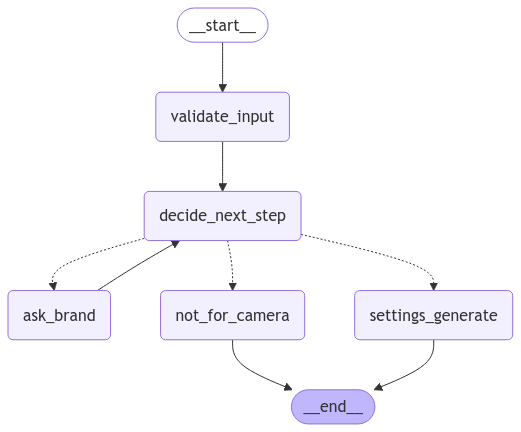

In [16]:
from IPython.display import display, Image

display(Image(app.get_graph().draw_mermaid_png()))


In [17]:
thread = {"configurable": {"thread_id": "1"}}

for event in app.stream({"question": "iso 설정에 대해 알려줘"}, config=thread, stream_mode="updates"):
    print(event)
    print("\n")

{'validate_input': {'question': 'iso 설정에 대해 알려줘', 'validation_results': {'camera_question': True, 'is_setting': False, 'choose_brand': False}}}


{'decide_next_step': {'question': 'iso 설정에 대해 알려줘', 'validation_results': {'camera_question': True, 'is_setting': False, 'choose_brand': False}, 'next_step': 'ask_brand'}}


{'__interrupt__': (Interrupt(value='알고 싶은 카메라 브랜드와 모델이 있으신가요?', resumable=True, ns=['ask_brand:c0539de1-5267-35b4-bc80-f734034d869c'], when='during'),)}




In [17]:
from langgraph.types import Command, interrupt
for event in app.stream(
    Command(resume="캐논의 200D가 알고 싶어."), thread, stream_mode="updates"
):
    print(event)
    print("\n")

{'ask_brand': {'question': 'iso 설정에 대해 알려줘', 'next_step': 'settings_generate', 'validation_results': {'camera_question': True, 'is_setting': False, 'choose_brand': True}, 'brand': 'canon', 'model': None}}


{'decide_next_step': {'question': 'iso 설정에 대해 알려줘', 'brand': 'canon', 'model': None, 'next_step': 'settings_generate', 'validation_results': {'camera_question': True, 'is_setting': False, 'choose_brand': True}}}


{'settings_generate': {'question': '"카메라에서 ISO 설정을 수동으로 조절하는 방법은 무엇인가요?"', 'brand': 'canon', 'model': None, 'next_step': 'settings_generate', 'validation_results': {'camera_question': True, 'is_setting': True, 'choose_brand': True}}}




In [19]:
thread = {"configurable": {"thread_id": "1"}}

def handle_stream(response):
    for event in response:
        if "__interrupt__" in event:
            interrupt_data = event["__interrupt__"]
            interrupt_value = interrupt_data[0].value  # Interrupt 메시지 값
            print(interrupt_value)  # 사용자에게 출력
            
            user_input = input("입력하세요: ")  # 사용자 입력 받기
            return Command(resume=user_input)  # 입력 값을 resume 명령으로 전달
        else:
            pass
        
# 첫 번째 요청 실행
response = app.stream({"question": "iso 설정에 대해 알려줘"}, config=thread, stream_mode="updates")
resume_command = handle_stream(response)

# 중단되었으면 사용자 입력을 받아 다시 실행
if resume_command:
    response = app.stream(resume_command, thread, stream_mode="updates")
    handle_stream(response)

알고 싶은 모델이 있으신가요?
